In [1]:
from nutils import *
import numpy, unittest

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections

In [2]:
nelems = 4
degree = 1
tol  = 1e-5
ndims = 1
extent = 1

In [3]:
domain, geom = mesh.rectilinear([numpy.linspace(0,extent,nelems+1)]*ndims)

In [4]:
# prepare residual
ns = function.Namespace()
ns.pi = numpy.pi
ns.x = geom
ns.basis = domain.basis('discont', degree=degree)
ns.u = 'basis_n ?lhs_n'
ns.k = 1   # diffusivity
h = extent / nelems
# Put element length in namespace
ns.h = h

# Tuning parameters
ns.beta = 1
ns.gamma = 50

# Stabilization parameters (all the same for an equidistant mesh)
ns.tauZero = ' gamma k / h'
ns.tauN    = ' gamma k / h'
ns.tauA    = ' gamma k / h'


# analytical solution and forcing vector


# BCs and analytical solution
ns.z = 2
ns.gl  = 'cos( z pi x_0 )'
ns.gr  = 'cos( z pi x_0 )'
ns.dgl = '-(z pi) sin( z pi x_0 )'
ns.dgr = '-(z pi) sin( z pi x_0 )'
ns.ddg = '-(z pi)^2 cos( z pi x_0 )'

ns.f   = ' - ddg'

In [5]:
# construct residual
# Element integrals
res = domain.integral('k basis_n,0 u_,0 - basis_n f' @ ns, geometry=ns.x, degree=degree*2)

# Interface integrals
#    part one                      |
#                                  v  minus might be necessary here because of jump definitions (likewise on second +)
res += domain.interfaces.integral(' [basis_n] n_0 k {u_,0} + beta k {basis_n,0} [u] n_0' @ ns, geometry=ns.x, degree=degree*2)
#    part two (stabilized)
res += domain.interfaces.integral(' tauA [basis_n] n_0 [u] n_0' @ ns, geometry=ns.x, degree=degree*2)

# Boundary integrals LHS
#    part one
res += domain.boundary.integral('- k basis_n u_,0 + beta k basis_n,0 u ' @ ns, geometry=ns.x, degree=degree*2)
#    part two (stabilized)
res += domain.boundary['left'].integral(' tauZero basis_n u ' @ ns, geometry=ns.x, degree=degree*2)
res += domain.boundary['right'].integral(' tauN basis_n u ' @ ns, geometry=ns.x, degree=degree*2)

# Boundary integrals RHS (weakly imposed boundary conditions) (including stabilization)
res -= domain.boundary['left'].integral(' ( beta k basis_n,0 + tauZero basis_n) gl ' @ ns, geometry=ns.x, degree=degree*2)
res -= domain.boundary['right'].integral(' ( beta k basis_n,0 + tauN basis_n) gr ' @ ns, geometry=ns.x, degree=degree*2)

In [6]:
# find lhs such that res == 0 and substitute this lhs in the namespace
# lhs = solver.solve_linear('lhs', res, constrain=cons)
lhs = solver.solve_linear('lhs', res)
ns = ns(lhs=lhs)

Here comes the Jacobian
(8, 8)
[[  2.04000000e+02  -6.00000000e+00  -2.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  2.00000000e+00   2.00000000e+02  -1.96000000e+02  -2.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -2.00000000e+00  -1.96000000e+02   2.00000000e+02   8.88178420e-16
   -2.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00  -2.00000000e+00   8.88178420e-16   2.00000000e+02
   -1.96000000e+02  -2.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00  -2.00000000e+00  -1.96000000e+02
    2.00000000e+02   8.88178420e-16  -2.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00  -2.00000000e+00
    8.88178420e-16   2.00000000e+02  -1.96000000e+02  -2.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   -2.00000000e+00  -1.96000000e+02   2.00000000e+02 

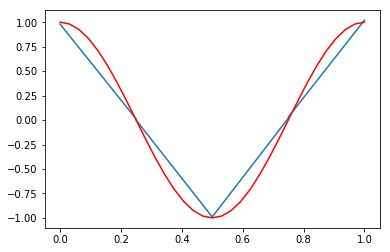

In [7]:
# plot solution
plt.figure()
bezier = domain.sample('bezier', 9)
x, u = bezier.eval([ns.x, ns.u])
x, gl = bezier.eval([ns.x, ns.gl])
plt.plot(x, u)
plt.plot(x, gl, 'r')
# plt.ylim(-2,2)